# Computer Vision Book

## LeNet implementation with Keras and MNIST dataset

---

In this notebook, we train a Convolutional Neural Network to classify images from the MNIST database.

### 1. Load MNIST Database

MNIST is one of the most famous datasets in the field of machine learning. 
 - It has 70,000 images of hand-written digits
 - Very straight forward to download
 - Images dimensions are 28x28
 - Grayscale images

In [1]:
from keras.datasets import mnist

# use Keras to import pre-shuffled MNIST database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("The MNIST database has a training set of %d examples." % len(X_train))
print("The MNIST database has a test set of %d examples." % len(X_test))

Using TensorFlow backend.


The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


### 2. Visualize the First Six Training Images

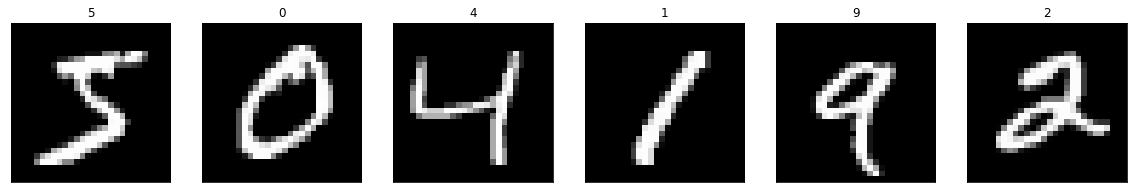

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

# plot first six training images
fig = plt.figure(figsize=(20,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))

### 3. View an Image in More Detail

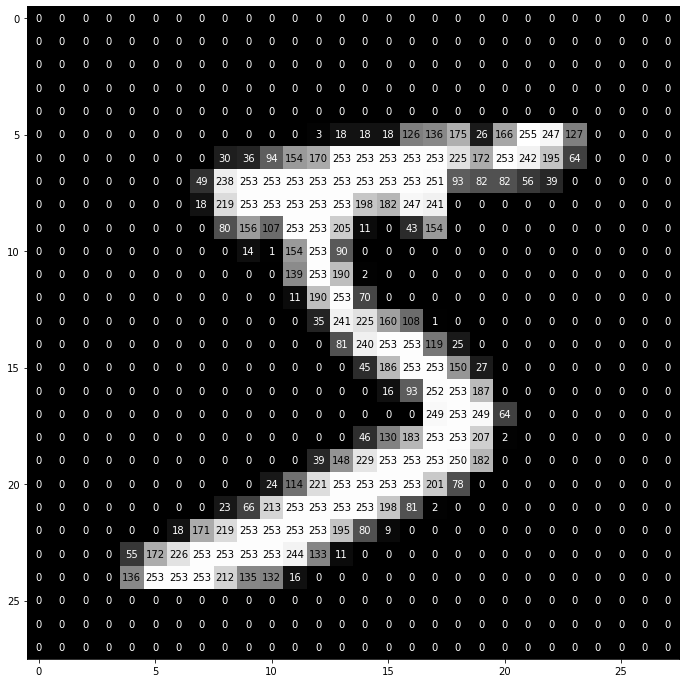

In [3]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax)

### 4. Preprocess input images: Rescale the Images by Dividing Every Pixel in Every Image by 255

In [4]:
# normalize the data to accelerate learning
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


### 5. Preprocess the labels: Encode Categorical Integer Labels Using a One-Hot Scheme

In [5]:
from keras.utils import np_utils

num_classes = 10 
# print first ten (integer-valued) training labels
print('Integer-valued labels:')
print(y_train[:10])

# one-hot encode the labels
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(y_train[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### 6. Reshape data to fit our CNN (and input_shape)

In [6]:
# input image dimensions 28x28 pixel images. 
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('image input shape: ', input_shape)
print('x_train shape:', X_train.shape)

image input shape:  (28, 28, 1)
x_train shape: (60000, 28, 28, 1)


### 7. Define the Model Architecture

![caption](lenet_architecture.png)

To implement LeNet-5 in Keras, read the [original paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) and extract the architecture information from pages 6, 7 and 8. Here are the main takeaways to build the LeNet-5 network:

- Number of filters in each CONV layer: you can see from the diagram (and defined in the paper) that the depth (number of filters) of each convolutional layer is as follows: C1 = 6, C3 = 16, C5 = 120 layers.
- Kernel size of each CONV layer: from the paper, the kernel_size is = 5 x 5
- A subsampling layer (POOL) is added after each convolutional layer. The receptive field of each unit is a 2 x 2 area (i.e. pool_size = 2). Note that the LeNet-5 creators used average pooling which computes the average value of its inputs instead of the max pooling layer that we used in our earlier projects which passes the maximum value of its inputs. You can try both if you are interested to see the difference. For this experiment, we are going to follow the paper architecture.
- Activation function: the creators of LeNet-5 used tanh activation function for the hidden layers because symmetric functions are believed to yield faster convergence compared to sigmoid functions. In general, you are strongly encouraged to add a ReLU activation function to every convolutional layer in your networks.


**Things to remember** 
- Always add a ReLU activation function to the **Conv2D** layers in your CNN. With the exception of the final layer in the network, Dense layers should also have a ReLU activation function.
- When constructing a network for classification, the final layer in the network should be a **Dense** (FC) layer with a softmax activation function. The number of nodes in the final layer should equal the total number of classes in the dataset.

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

In [8]:
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))

# S2 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C3 Convolutional Layer
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# S4 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(Flatten())

# FC6 Fully Connected Layer
model.add(Dense(84, activation='tanh'))

# Output Layer with softmax activation
model.add(Dense(10, activation='softmax'))

# print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
__________

### 8. Compile the Model

In this exercise, we will use Adam optimizer

In [10]:
# the loss function is categorical cross entropy since we have multiple classes (10) 


# compile the model by defining the loss function, optimizer, and performance metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 9. Train the Model

In [12]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.06423, saving model to model.weights.best.hdf5
31s - loss: 0.1712 - acc: 0.9485 - val_loss: 0.0642 - val_acc: 0.9785
Epoch 2/20
Epoch 00001: val_loss improved from 0.06423 to 0.05698, saving model to model.weights.best.hdf5
33s - loss: 0.0629 - acc: 0.9810 - val_loss: 0.0570 - val_acc: 0.9828
Epoch 3/20
Epoch 00002: val_loss improved from 0.05698 to 0.03590, saving model to model.weights.best.hdf5
30s - loss: 0.0456 - acc: 0.9867 - val_loss: 0.0359 - val_acc: 0.9880
Epoch 4/20
Epoch 00003: val_loss did not improve
30s - loss: 0.0374 - acc: 0.9882 - val_loss: 0.0406 - val_acc: 0.9873
Epoch 5/20
Epoch 00004: val_loss improved from 0.03590 to 0.03150, saving model to model.weights.best.hdf5
30s - loss: 0.0301 - acc: 0.9906 - val_loss: 0.0315 - val_acc: 0.9900
Epoch 6/20
Epoch 00005: val_loss did not improve
30s - loss: 0.0254 - acc: 0.9919 - val_loss: 0.0360 - val_acc: 0.9885
Epoch 7/

### 10. Load the Model with the Best Classification Accuracy on the Validation Set

In [13]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

### 11. Calculate the Classification Accuracy on the Test Set

In [14]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.0000%


## 12. evaluate the model

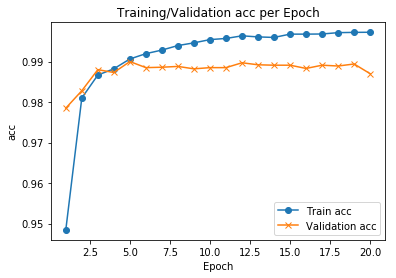

In [15]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + hist.history['acc'], 'o-')
ax.plot([None] + hist.history['val_acc'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')
plt.show()

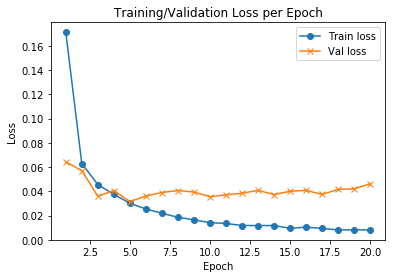

In [16]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', "Val loss"], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()